In [6]:
import geopandas
# import geoplot
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr
#import matplotlib
#matplotlib.use('Agg')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tigramite.data_processing import DataFrame
import netCDF4
import os
import re
#import seaborn as sns
#from datetime import datetime
import datetime
#from sklearn.linear_model import LinearRegression

from random import seed
from random import randint

import warnings
warnings.filterwarnings("ignore")

import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
ids = [int(i.split('/')[-1].split('.')[0]) for i in np.array(glob.glob('/exports/geos.ed.ac.uk/climate_change/users/carla/ecad/merged-stations-19820101-20141231/*.nc'))]
# print(ids)
j1 = 120
j2 = 243
print(ids)
years = np.zeros(len(ids))
n = 0

ts = [[1982,1989],[1985,1994],[1990,1999],[1995,2004],[2000,2009],[2005,2014]]
ps = ['1980-1990','1985-1994','1990-2000','1995-2004','2000-2010','2005-2014']

for h in range(6):
    print(ts[h])
    for j in range(len(ids)):
        nri = xr.open_dataset('/exports/geos.ed.ac.uk/climate_change/users/carla/ecad/merged-stations-19820101-20141231/'+str(ids[j])+'.nc')
        if (nri.time[0].dt.month.values != 1) | (nri.time[0].dt.day.values != 1):
            time_start = np.datetime64(str(nri.time[0].dt.year.values+1) + '-01-01').astype('datetime64[s]')
            y1 = nri.time[0].dt.year.values+1
        else:
            time_start = nri.time[0].values
            y1 = int(nri.time[0].dt.year.values)
        print(y1)
        if y1 < ts[h][0]: 
            time_start = np.datetime64(str(ts[h][0]) + '-12-31').astype('datetime64[s]')
            y1 = ts[h][0]
            print(y1)

        if (nri.time[-1].dt.month.values != 12) | (nri.time[-1].dt.day.values != 31):
            time_end = np.datetime64(str(nri.time[-1].dt.year.values-1) + '-12-31').astype('datetime64[s]')
            y2 = nri.time[-1].dt.year.values-1
        else:
            time_end = nri.time[-1].values
            y2 = int(nri.time[-1].dt.year.values)

        if y2 > ts[h][1]: 
                y2 = ts[h][1]
                time_end = np.datetime64(str(ts[h][1]) + '-12-31').astype('datetime64[s]')

        print(y2)
        d = (y2-y1)+1
        print(d)
        if d > 5:
            stn = nri.sel(time=~((nri.time.dt.month == 2) & (nri.time.dt.day == 29))).sel(time = slice(time_start,time_end))    
            yr_nan = stn.TN.values.reshape(d,365)[:,j1:j2].mean(axis =1)*stn.TX.values.reshape(d,365)[:,j1:j2].mean(axis =1)*stn.QQ.values.reshape(d,365)[:,j1:j2].mean(axis =1)*stn.CC.values.reshape(d,365)[:,j1:j2].mean(axis =1)*stn.merraAOD.values.reshape(d,365)[:,j1:j2].mean(axis =1)

            years[j] = np.where(~np.isnan(yr_nan))[0].shape[0]

            if np.where(~np.isnan(yr_nan))[0].shape[0]>5:

                var_names = ['tmin','tmax','sw','cloudiness','aod']

                tn_ = stn.TN.values.reshape(d,365)[np.where(~np.isnan(yr_nan))[0],j1:j2]
                tx_ = stn.TX.values.reshape(d,365)[np.where(~np.isnan(yr_nan))[0],j1:j2]
                qq_ = stn.QQ.values.reshape(d,365)[np.where(~np.isnan(yr_nan))[0],j1:j2]
                cc_ = stn.CC.values.reshape(d,365)[np.where(~np.isnan(yr_nan))[0],j1:j2]
                aod_ = stn.merraAOD.values.reshape(d,365)[np.where(~np.isnan(yr_nan))[0],j1:j2]

                dataStacked = np.stack([(tn_-np.mean(tn_)), (tx_-np.mean(tx_)), (qq_-np.mean(qq_)), (cc_-np.mean(cc_)), (aod_-np.mean(aod_))])
                data = {i: dataStacked[:,i,:].transpose() for i in range(np.where(~np.isnan(yr_nan))[0].shape[0])}
                dataframe = DataFrame(data, analysis_mode = 'multiple', var_names = var_names)

                if n == 0:

                    tn = (tn_ - np.mean(tn_))#/np.std(tn_)
                    tx = (tx_ - np.mean(tx_))#/np.std(tx_)
                    qq = (qq_ - np.mean(qq_))#/np.std(qq_)
                    cc = (cc_ - np.mean(cc_))#/np.std(cc_)
                    aod = (aod_ - np.mean(aod_))#/np.std(aod_)

                else:

                    tn = np.concatenate([tn, (tn_-np.mean(tn_))], axis = 0)
                    tx = np.concatenate([tx, (tx_-np.mean(tx_))], axis = 0)
                    qq = np.concatenate([qq, (qq_-np.mean(qq_))], axis = 0)
                    cc = np.concatenate([cc, (cc_-np.mean(cc_))], axis = 0)
                    aod = np.concatenate([aod, (aod_-np.mean(aod_))], axis = 0)
                n = n+1

            dataStacked = np.stack([tn,tx,qq,cc,aod])

            np.save('/exports/geos.ed.ac.uk/climate_change/users/carla/results/stations/stacked-'+ps[h]+'.npy', dataStacked)
            np.save('/exports/geos.ed.ac.uk/climate_change/users/carla/results/stations/years-'+ps[h]+'.npy', years)


In [4]:
nri

<xarray.Dataset>
Dimensions:   (time: 5966)
Coordinates:
  * time      (time) datetime64[ns] 1998-09-01 1998-09-02 ... 2014-12-31
Data variables:
    CC        (time) float64 ...
    QQ        (time) float64 ...
    TN        (time) float64 ...
    TX        (time) float64 ...
    merraAOD  (time) float32 ...
    claraCLT  (time) float64 ...

In [7]:
xr.open_dataset('/exports/geos.ed.ac.uk/climate_change/users/carla/eobs/tn_ens_mean_0.25deg_reg_v26.0e.nc')

<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 26479)
Coordinates:
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2022-06-30
Data variables:
    tn         (time, latitude, longitude) float32 ...
Attributes:
    E-OBS_version:  26.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Sep 30 07:43:02 2022: ncks --no-abc -d time,0,26478 /...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....

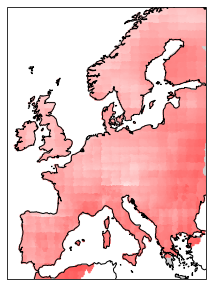

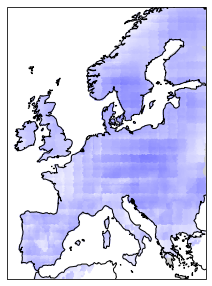

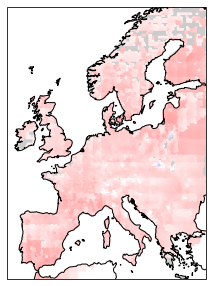

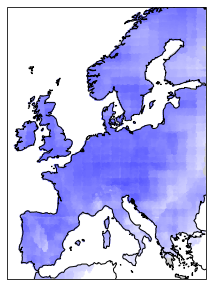

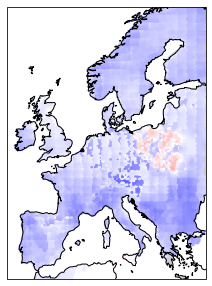

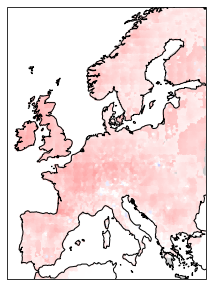

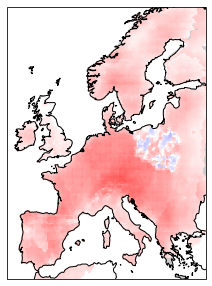

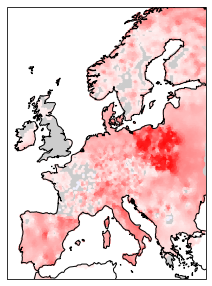

In [10]:
station_locDF = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/home/s2135337/carla/results/eobs/v26/results/*.npy')]

station_locDF = pd.DataFrame()
station_locDF['id'] = np.arange(len(latlon))

station_locDF['lat'] = np.nan
station_locDF['lon'] = np.nan

station_locDF['AOD-CC'] = np.nan
station_locDF['AOD-->CC'] = '--'

station_locDF['AOD-SW'] = np.nan
station_locDF['AOD-->SW'] = '--'

station_locDF['AOD-Tmin'] = np.nan
station_locDF['AOD-->Tmin'] = '--'

station_locDF['CC-SW'] = np.nan
station_locDF['CC-->SW'] = '--'

station_locDF['CC-Tmax'] = np.nan
station_locDF['CC-->Tmax'] = '--'

station_locDF['CC-Tmin'] = np.nan
station_locDF['CC-->Tmin'] = '--'

station_locDF['SW-Tmax'] = np.nan
station_locDF['SW-->Tmax'] = '--'

station_locDF['Tmax-Tmin'] = np.nan
station_locDF['Tmax-->Tmin'] = '--'


station_locDF.columns = station_locDF.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(station_locDF.id == i)[0][0]
    station_locDF.loc[k,'lat'] = latlon[i][0]
    station_locDF.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('//home/s2135337/carla/results/eobs/v26/results/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)

    if result[2][4][3,0] <= 0.01:
        station_locDF.loc[k, 'AOD-CC'] = result[1][4][3,0]
        station_locDF.loc[k, 'AOD-->CC'] = result[0][4][3,0]

    if result[2][4][2,0]<= 0.01:
        station_locDF.loc[k, 'AOD-SW'] = result[1][4][2,0]
        station_locDF.loc[k, 'AOD-->SW'] = result[0][4][2,0]
        
    if result[2][4][0,0]<= 0.01:
        station_locDF.loc[k, 'AOD-Tmin'] = result[1][4][0,0]
        station_locDF.loc[k, 'AOD-->Tmin'] = result[0][4][0,0]

    if result[2][3][2,0]<= 0.01:
        station_locDF.loc[k, 'CC-SW'] = result[1][3][2,0]
        station_locDF.loc[k, 'CC-->SW'] = result[0][3][2,0]

    if result[2][3][1,0]<= 0.01:
        station_locDF.loc[k, 'CC-Tmax'] = result[1][3][1,0]
        station_locDF.loc[k, 'CC-->Tmax'] = result[0][3][1,0]

    if result[2][3][0,0]<= 0.01:
        station_locDF.loc[k, 'CC-Tmin'] = result[1][3][0,0]
        station_locDF.loc[k, 'CC-->Tmin'] = result[0][3][0,0]

    if result[2][2][1,0]<= 0.01:
        station_locDF.loc[k, 'SW-Tmax'] = result[1][2][1,0]
        station_locDF.loc[k, 'SW-->Tmax'] = result[0][2][1,0]

    if result[2][2][0,0]<= 0.01:
        station_locDF.loc[k, 'SW-Tmin'] = result[1][2][0,0]
        station_locDF.loc[k, 'SW-->Tmin'] = result[0][2][0,0]

    if result[2][1][0,0]<= 0.01:
        # print('yes')
        station_locDF.loc[k, 'Tmax-Tmin'] = result[1][1][0,0]
        station_locDF.loc[k, 'Tmax-->Tmin'] = result[0][1][0,0]

        

crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon'], station_locDF['lat']))

cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin']

for i in range(8):
    
    fig = plt.figure(figsize=(5, 5), facecolor = 'white')
    spec = gridspec.GridSpec(ncols=1, nrows=1,
                                 width_ratios=[1 for i in range(1)], wspace=0.1,
                                 hspace=0.3, height_ratios=[1 for i in range(1)])
    ax = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())
    eu.plot(ax=ax,alpha=0.4,color="grey")
    geo_df.plot(column = cols[i],ax=ax,markersize=3, cmap = 'bwr', vmin = -1, vmax = 1)
    # geo_df[geo_df['id_active']=="no"].plot(ax=ax,markersize=200, alpha=0.4,color="red", label="Inactive Stores")
    ax.set_xlim(-12,30)
    ax.set_ylim(35,70)
    # ax.set_title(cols[i], fontsize = 22)
    ax.coastlines()
    # plt.show()
    plt.savefig('/home/s2135337/carla/results/eobs/v26/Europe-map-'+cols[i]+'.png', bbox_inches='tight', dpi = 500)

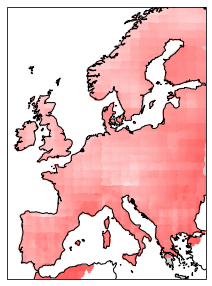

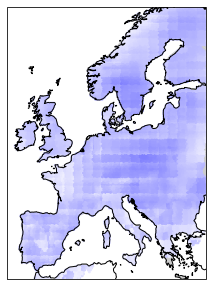

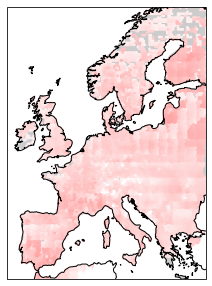

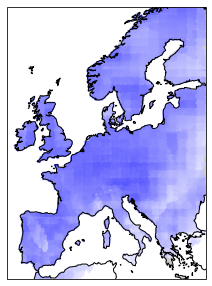

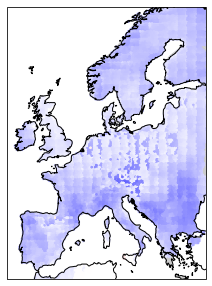

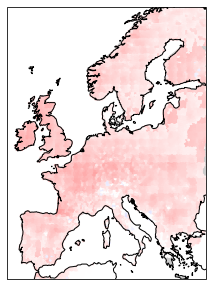

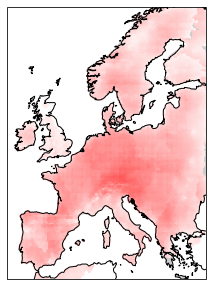

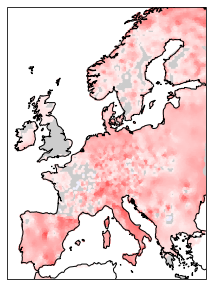

In [11]:
station_locDF = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/home/s2135337/carla/results/eobs/v27/results/*.npy')]

station_locDF = pd.DataFrame()
station_locDF['id'] = np.arange(len(latlon))

station_locDF['lat'] = np.nan
station_locDF['lon'] = np.nan

station_locDF['AOD-CC'] = np.nan
station_locDF['AOD-->CC'] = '--'

station_locDF['AOD-SW'] = np.nan
station_locDF['AOD-->SW'] = '--'

station_locDF['AOD-Tmin'] = np.nan
station_locDF['AOD-->Tmin'] = '--'

station_locDF['CC-SW'] = np.nan
station_locDF['CC-->SW'] = '--'

station_locDF['CC-Tmax'] = np.nan
station_locDF['CC-->Tmax'] = '--'

station_locDF['CC-Tmin'] = np.nan
station_locDF['CC-->Tmin'] = '--'

station_locDF['SW-Tmax'] = np.nan
station_locDF['SW-->Tmax'] = '--'

station_locDF['Tmax-Tmin'] = np.nan
station_locDF['Tmax-->Tmin'] = '--'


station_locDF.columns = station_locDF.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(station_locDF.id == i)[0][0]
    station_locDF.loc[k,'lat'] = latlon[i][0]
    station_locDF.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('//home/s2135337/carla/results/eobs/v27/results/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)

    if result[2][4][3,0] <= 0.01:
        station_locDF.loc[k, 'AOD-CC'] = result[1][4][3,0]
        station_locDF.loc[k, 'AOD-->CC'] = result[0][4][3,0]

    if result[2][4][2,0]<= 0.01:
        station_locDF.loc[k, 'AOD-SW'] = result[1][4][2,0]
        station_locDF.loc[k, 'AOD-->SW'] = result[0][4][2,0]
        
    if result[2][4][0,0]<= 0.01:
        station_locDF.loc[k, 'AOD-Tmin'] = result[1][4][0,0]
        station_locDF.loc[k, 'AOD-->Tmin'] = result[0][4][0,0]

    if result[2][3][2,0]<= 0.01:
        station_locDF.loc[k, 'CC-SW'] = result[1][3][2,0]
        station_locDF.loc[k, 'CC-->SW'] = result[0][3][2,0]

    if result[2][3][1,0]<= 0.01:
        station_locDF.loc[k, 'CC-Tmax'] = result[1][3][1,0]
        station_locDF.loc[k, 'CC-->Tmax'] = result[0][3][1,0]

    if result[2][3][0,0]<= 0.01:
        station_locDF.loc[k, 'CC-Tmin'] = result[1][3][0,0]
        station_locDF.loc[k, 'CC-->Tmin'] = result[0][3][0,0]

    if result[2][2][1,0]<= 0.01:
        station_locDF.loc[k, 'SW-Tmax'] = result[1][2][1,0]
        station_locDF.loc[k, 'SW-->Tmax'] = result[0][2][1,0]

    if result[2][2][0,0]<= 0.01:
        station_locDF.loc[k, 'SW-Tmin'] = result[1][2][0,0]
        station_locDF.loc[k, 'SW-->Tmin'] = result[0][2][0,0]

    if result[2][1][0,0]<= 0.01:
        # print('yes')
        station_locDF.loc[k, 'Tmax-Tmin'] = result[1][1][0,0]
        station_locDF.loc[k, 'Tmax-->Tmin'] = result[0][1][0,0]

        

crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon'], station_locDF['lat']))

cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin']

for i in range(8):
    
    fig = plt.figure(figsize=(5, 5), facecolor = 'white')
    spec = gridspec.GridSpec(ncols=1, nrows=1,
                                 width_ratios=[1 for i in range(1)], wspace=0.1,
                                 hspace=0.3, height_ratios=[1 for i in range(1)])
    ax = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())
    eu.plot(ax=ax,alpha=0.4,color="grey")
    geo_df.plot(column = cols[i],ax=ax,markersize=3, cmap = 'bwr', vmin = -1, vmax = 1)
    # geo_df[geo_df['id_active']=="no"].plot(ax=ax,markersize=200, alpha=0.4,color="red", label="Inactive Stores")
    ax.set_xlim(-12,30)
    ax.set_ylim(35,70)
    # ax.set_title(cols[i], fontsize = 22)
    ax.coastlines()
    # plt.show()
    plt.savefig('/home/s2135337/carla/results/eobs/v27/Europe-map-'+cols[i]+'.png', bbox_inches='tight', dpi = 500)

In [45]:
station_locDF = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/home/s2135337/carla/results/cmip6/causal-effects-HadGEM3-01-14/*.npy')]

station_locDF = pd.DataFrame()
station_locDF['id'] = np.arange(len(latlon))

station_locDF['lat'] = np.nan
station_locDF['lon'] = np.nan

station_locDF.columns = station_locDF.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(station_locDF.id == i)[0][0]
    station_locDF.loc[k,'lat'] = latlon[i][0]
    station_locDF.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/home/s2135337/carla/results/cmip6/causal-effects-HadGEM3-01-14/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['[]','[W/m2]','[K}','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            
            if n == 0:
                station_locDF.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                station_locDF.loc[k, cols[n]] = result[n][0]*100
            else:
                station_locDF.loc[k, cols[n]] = result[n][0]

In [46]:
station_locDF['lon-new'] = station_locDF['lon'].astype(float) - 2
station_locDF['lat-new'] = station_locDF['lat'].astype(float) - 1

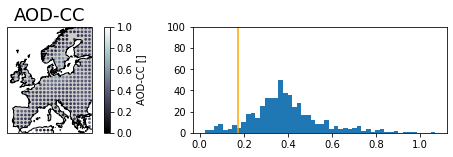

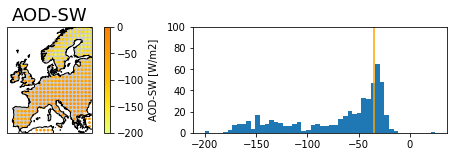

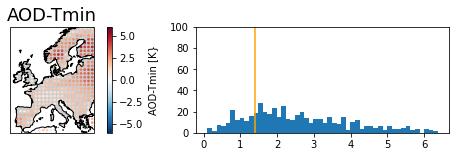

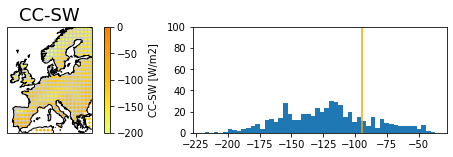

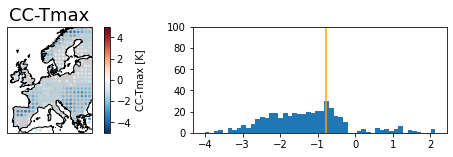

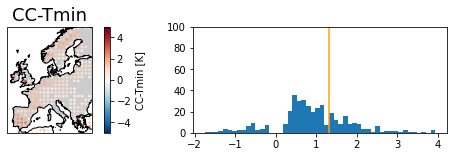

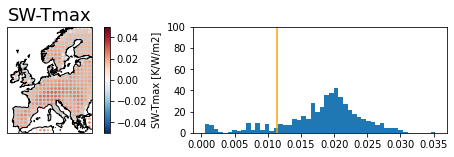

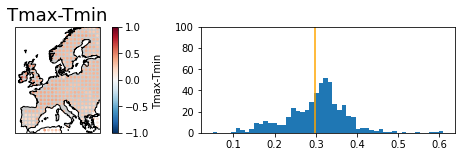

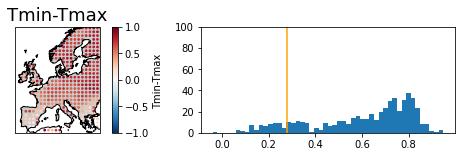

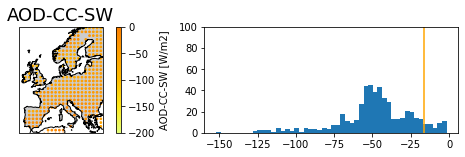

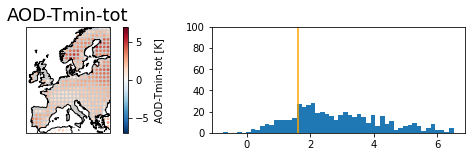

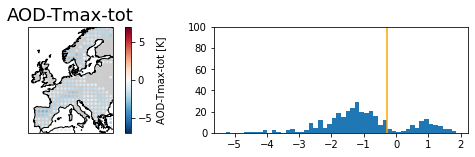

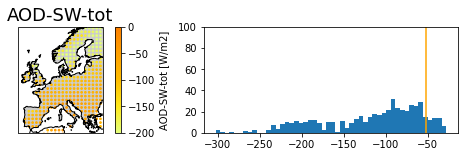

In [55]:
crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon-new'], station_locDF['lat-new']))

# cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin']

vmax = [1,0,6,0,5,5,0.05,1,1,0,7,7,0]
vmin = [0,-200,-6,-200,-5,-5,-0.05,-1,-1,-200,-7,-7,-200]
cmap = ['bone','Wistia','RdBu_r','Wistia','RdBu_r','RdBu_r','RdBu_r','RdBu_r','RdBu_r','Wistia','RdBu_r','RdBu_r','Wistia']


results = np.load('/home/s2135337/carla/results/cmip6/ce-HadGEM3-01-14.npy')
        
for i in range(13):
    
    fig = plt.figure(figsize=(10, 30))
    ax1 = fig.add_subplot(13,2,(i+1)*2-1, projection=ccrs.PlateCarree())
    eu.plot(ax=ax1,alpha=0.4,color="grey")
    img = geo_df.plot(column = cols[i],ax=ax1,markersize=3, cmap = cmap[i], vmin = vmin[i], vmax = vmax[i], legend = True, legend_kwds = {'label':cols[i]+ ' ' + lab[i], 'shrink': 1})
    img._A = []
    ax1.set_xlim(-12,30)
    ax1.set_ylim(35,70)
    ax1.coastlines()
    ax1.set_title(cols[i], fontsize = 18)
    
    ax2 = fig.add_subplot(13,2,(i+1)*2)
    fig.add_axes(ax2)
    ax2.hist(geo_df[cols[i]], bins = 50)
    ax2.set_ylim(0,100)
    ax2.vlines(results[i,0],0,100, color = 'orange')
    
    # spec = gridspec.GridSpec(ncols=1, nrows=1,
    #                              width_ratios=[1 for i in range(1)], wspace=0.1,
    #                              hspace=0.3, height_ratios=[1 for i in range(1)])
    # ax = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())

plt.savefig('/home/s2135337/carla/results/plots/HadGEM3.png', dpi = 500)

In [ ]:
##### crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon-new'], station_locDF['lat-new']))

# cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin']

vmax = [2,200,6,200,6,6,0.1,1,1,200,7,7,200]
vmin = [-2,-200,-6,-200,-6,-6,-0.1,-1,-1,-200,-7,-7,-200]
cmap = ['bone','Wistia','RdBu']

for i in range(13):
    
    fig = plt.figure(figsize=(7, 4), facecolor = 'white')
    spec = gridspec.GridSpec(ncols=1, nrows=1,
                                 width_ratios=[1 for i in range(1)], wspace=0.1,
                                 hspace=0.3, height_ratios=[1 for i in range(1)])
    ax = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())
    eu.plot(ax=ax,alpha=0.4,color="grey")
    geo_df.plot(column = cols[i],ax=ax,markersize=30, cmap = 'bwr', vmin = vmin[i], vmax = vmax[i], legend = True, legend_kwds = {'label':cols[i]+ ' ' + lab[i]})
    ax.set_xlim(-12,30)
    ax.set_ylim(35,70)
    ax.coastlines()
    plt.savefig('/home/s2135337/carla/results/plots/gridded-CE/HadGEM3-'+cols[i]+'.png', dpi = 500)

In [57]:
station_locDF = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/home/s2135337/carla/results/cmip6/causal-effects-CanESM5-01-14/*.npy')]

station_locDF = pd.DataFrame()
station_locDF['id'] = np.arange(len(latlon))

station_locDF['lat'] = np.nan
station_locDF['lon'] = np.nan

station_locDF.columns = station_locDF.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(station_locDF.id == i)[0][0]
    station_locDF.loc[k,'lat'] = latlon[i][0]
    station_locDF.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/home/s2135337/carla/results/cmip6/causal-effects-CanESM5-01-14/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['[]','[W/m2]','[K}','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            
            if n == 0:
                station_locDF.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                station_locDF.loc[k, cols[n]] = result[n][0]*100
            else:
                station_locDF.loc[k, cols[n]] = result[n][0]

FileNotFoundError: [Errno 2] No such file or directory: '/home/s2135337/carla/results/cmip6/causal-effects-CanESM5-01-14/65.577--36.56.npy'

In [46]:
station_locDF['lon-new'] = station_locDF['lon'].astype(float) - 2
station_locDF['lat-new'] = station_locDF['lat'].astype(float) - 1

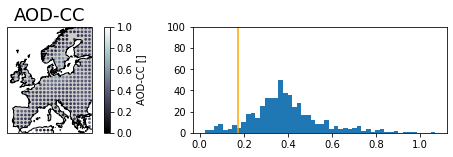

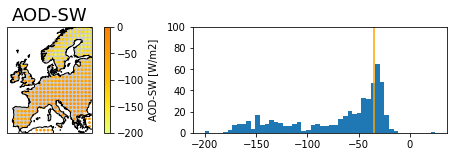

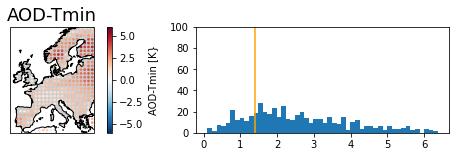

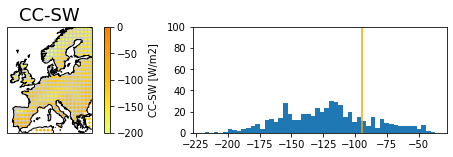

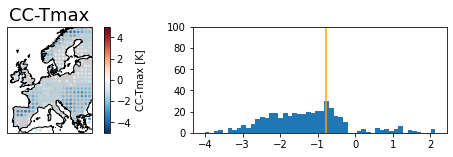

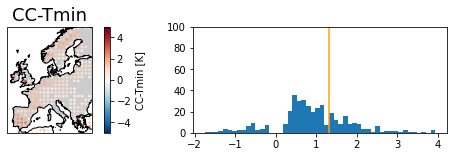

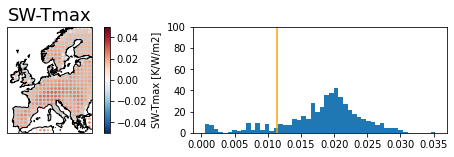

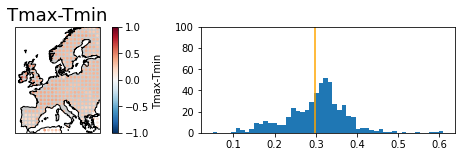

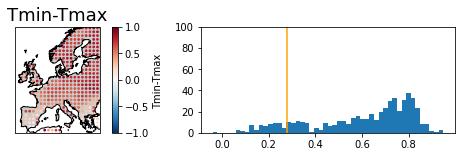

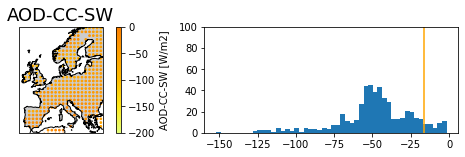

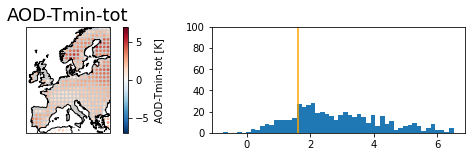

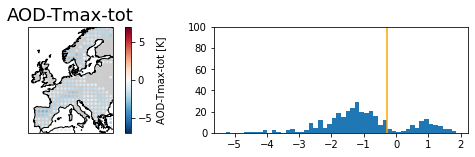

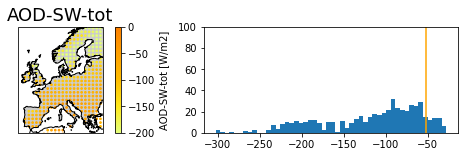

In [55]:
crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon-new'], station_locDF['lat-new']))

# cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin']

vmax = [1,0,6,0,5,5,0.05,1,1,0,7,7,0]
vmin = [0,-200,-6,-200,-5,-5,-0.05,-1,-1,-200,-7,-7,-200]
cmap = ['bone','Wistia','RdBu_r','Wistia','RdBu_r','RdBu_r','RdBu_r','RdBu_r','RdBu_r','Wistia','RdBu_r','RdBu_r','Wistia']


results = np.load('/home/s2135337/carla/results/cmip6/ce-HadGEM3-01-14.npy')
        
for i in range(13):
    
    fig = plt.figure(figsize=(10, 30))
    ax1 = fig.add_subplot(13,2,(i+1)*2-1, projection=ccrs.PlateCarree())
    eu.plot(ax=ax1,alpha=0.4,color="grey")
    img = geo_df.plot(column = cols[i],ax=ax1,markersize=3, cmap = cmap[i], vmin = vmin[i], vmax = vmax[i], legend = True, legend_kwds = {'label':cols[i]+ ' ' + lab[i], 'shrink': 1})
    img._A = []
    ax1.set_xlim(-12,30)
    ax1.set_ylim(35,70)
    ax1.coastlines()
    ax1.set_title(cols[i], fontsize = 18)
    
    ax2 = fig.add_subplot(13,2,(i+1)*2)
    fig.add_axes(ax2)
    ax2.hist(geo_df[cols[i]], bins = 50)
    ax2.set_ylim(0,100)
    ax2.vlines(results[i,0],0,100, color = 'orange')
    
    # spec = gridspec.GridSpec(ncols=1, nrows=1,
    #                              width_ratios=[1 for i in range(1)], wspace=0.1,
    #                              hspace=0.3, height_ratios=[1 for i in range(1)])
    # ax = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())

plt.savefig('/home/s2135337/carla/results/plots/CanESM5.png', dpi = 500)

In [ ]:
##### crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon-new'], station_locDF['lat-new']))

# cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin']

vmax = [2,200,6,200,6,6,0.1,1,1,200,7,7,200]
vmin = [-2,-200,-6,-200,-6,-6,-0.1,-1,-1,-200,-7,-7,-200]
cmap = ['bone','Wistia','RdBu']

for i in range(13):
    
    fig = plt.figure(figsize=(7, 4), facecolor = 'white')
    spec = gridspec.GridSpec(ncols=1, nrows=1,
                                 width_ratios=[1 for i in range(1)], wspace=0.1,
                                 hspace=0.3, height_ratios=[1 for i in range(1)])
    ax = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())
    eu.plot(ax=ax,alpha=0.4,color="grey")
    geo_df.plot(column = cols[i],ax=ax,markersize=30, cmap = 'bwr', vmin = vmin[i], vmax = vmax[i], legend = True, legend_kwds = {'label':cols[i]+ ' ' + lab[i]})
    ax.set_xlim(-12,30)
    ax.set_ylim(35,70)
    ax.coastlines()
    plt.savefig('/home/s2135337/carla/results/plots/gridded-CE/HadGEM3-'+cols[i]+'.png', dpi = 500)

In [2]:
station_locDF = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/home/s2135337/carla/results/eobs/causal-effects-v27-01-14/*.npy')]

station_locDF = pd.DataFrame()
station_locDF['id'] = np.arange(len(latlon))

station_locDF['lat'] = np.nan
station_locDF['lon'] = np.nan

station_locDF.columns = station_locDF.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(station_locDF.id == i)[0][0]
    station_locDF.loc[k,'lat'] = latlon[i][0]
    station_locDF.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/home/s2135337/carla/results/eobs/causal-effects-v27-01-21/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['[]','[W/m2]','[K}','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            if n == 0:
                station_locDF.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                station_locDF.loc[k, cols[n]] = result[n][0]*100
            else:
                station_locDF.loc[k, cols[n]] = result[n][0]

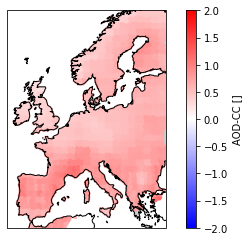

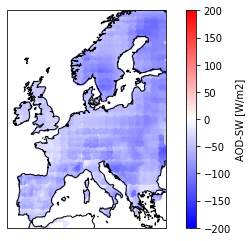

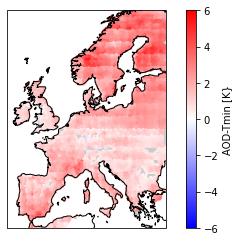

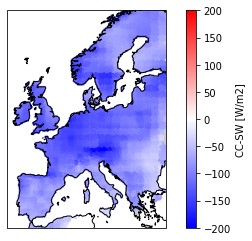

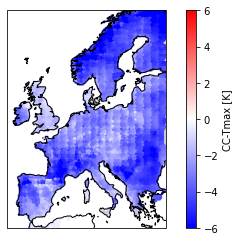

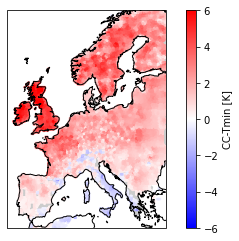

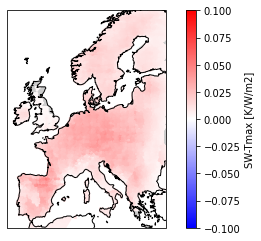

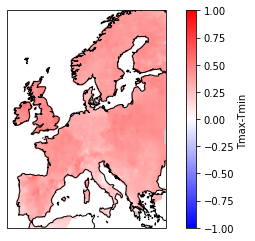

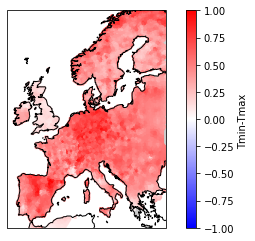

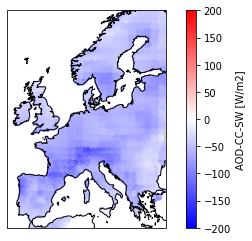

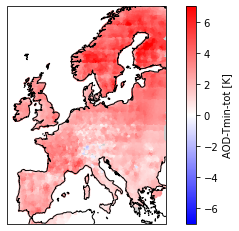

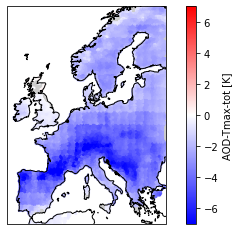

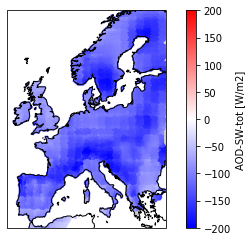

In [4]:
crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon'], station_locDF['lat']))

# cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin']

vmax = [2,200,6,200,6,6,0.1,1,1,200,7,7,200]
vmin = [-2,-200,-6,-200,-6,-6,-0.1,-1,-1,-200,-7,-7,-200]
cmap = ['bone','Wistia','RdBu']

for i in range(13):
    
    fig = plt.figure(figsize=(7, 4), facecolor = 'white')
    spec = gridspec.GridSpec(ncols=1, nrows=1,
                                 width_ratios=[1 for i in range(1)], wspace=0.1,
                                 hspace=0.3, height_ratios=[1 for i in range(1)])
    ax = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())
    eu.plot(ax=ax,alpha=0.4,color="grey")
    geo_df.plot(column = cols[i],ax=ax,markersize=3, cmap = 'bwr', vmin = vmin[i], vmax = vmax[i], legend = True, legend_kwds = {'label':cols[i]+ ' ' + lab[i]})
    ax.set_xlim(-12,30)
    ax.set_ylim(35,70)
    ax.coastlines()
    plt.savefig('/home/s2135337/carla/results/plots/gridded-CE/EOBSv27-'+cols[i]+'.png', dpi = 500)

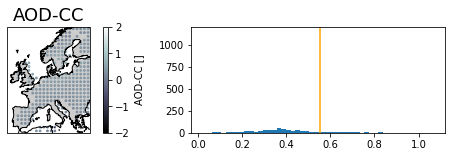

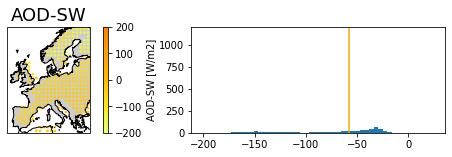

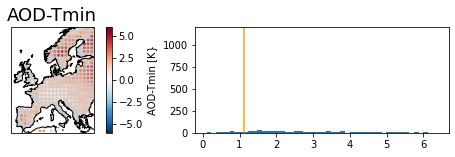

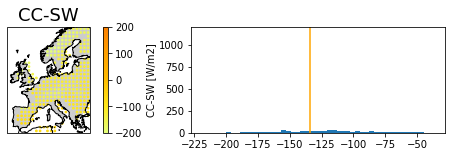

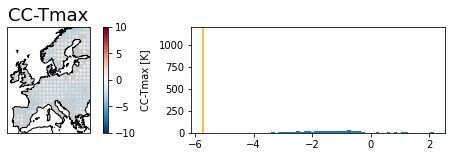

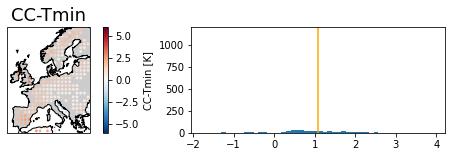

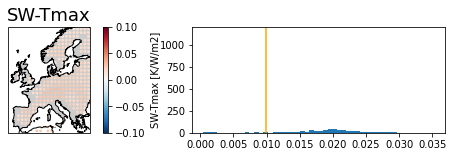

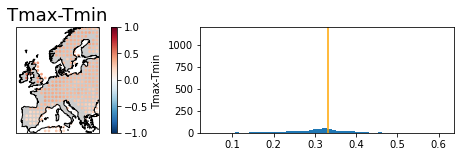

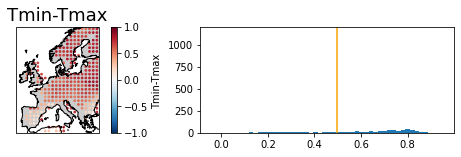

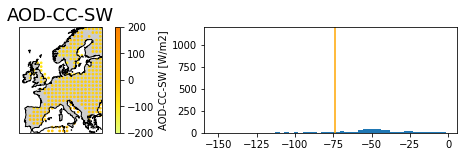

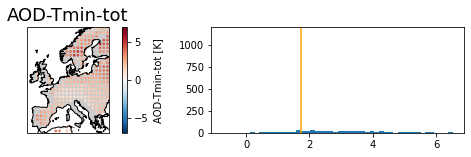

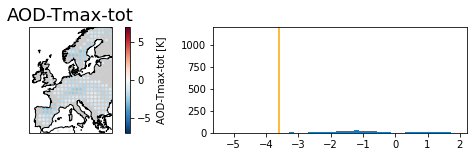

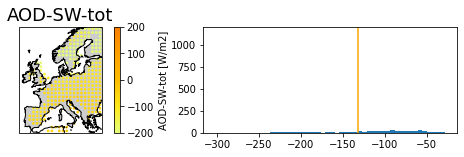

In [56]:
crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon'], station_locDF['lat']))

# cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin']

vmax = [2,200,6,200,10,6,0.1,1,1,200,7,7,200]
vmin = [-2,-200,-6,-200,-10,-6,-0.1,-1,-1,-200,-7,-7,-200]
cmap = ['bone','Wistia','RdBu_r','Wistia','RdBu_r','RdBu_r','RdBu_r','RdBu_r','RdBu_r','Wistia','RdBu_r','RdBu_r','Wistia']


results = np.load('/home/s2135337/carla/results/stations/ce-stations-01-14.npy')
        
for i in range(13):
    
    fig = plt.figure(figsize=(10, 30))
    ax1 = fig.add_subplot(13,2,(i+1)*2-1, projection=ccrs.PlateCarree())
    eu.plot(ax=ax1,alpha=0.4,color="grey")
    img = geo_df.plot(column = cols[i],ax=ax1,markersize=3, cmap = cmap[i], vmin = vmin[i], vmax = vmax[i], legend = True, legend_kwds = {'label':cols[i]+ ' ' + lab[i], 'shrink': 1})
    img._A = []
    ax1.set_xlim(-12,30)
    ax1.set_ylim(35,70)
    ax1.coastlines()
    ax1.set_title(cols[i], fontsize = 18)
    
    ax2 = fig.add_subplot(13,2,(i+1)*2)
    fig.add_axes(ax2)
    ax2.hist(geo_df[cols[i]], bins = 50)
    ax2.set_ylim(0,1200)
    ax2.vlines(results[i,0],0,1200, color = 'orange')
    
    # spec = gridspec.GridSpec(ncols=1, nrows=1,
    #                              width_ratios=[1 for i in range(1)], wspace=0.1,
    #                              hspace=0.3, height_ratios=[1 for i in range(1)])
    # ax = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())

plt.savefig('/home/s2135337/carla/results/plots/EOBSv27.png', dpi = 500)

In [35]:
e = xr.open_dataset('/home/s2135337/carla/ceres-clara-merra-eobs27-eobs26-merged-20010101-20211231.nc')

(array([[ 0.,  0.,  0., ..., 12., 44., 32.],
        [ 0.,  0.,  0., ..., 12., 44., 33.],
        [ 0.,  0.,  0., ..., 12., 44., 34.],
        ...,
        [ 0.,  0.,  0., ..., 24., 28., 52.],
        [ 0.,  0.,  0., ..., 24., 28., 52.],
        [ 0.,  0.,  0., ..., 24., 28., 52.]]),
 array([ 12.49415016,  21.24473515,  29.99532013,  38.74590511,
         47.4964901 ,  56.24707508,  64.99766006,  73.74824505,
         82.49883003,  91.24941502, 100.        ]),
 <a list of 280 BarContainer objects>)

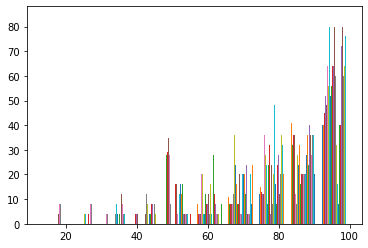

In [40]:
plt.hist(e.ceresCLT.values[0])

In [2]:
station_locDF = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/home/s2135337/carla/results/cmip6/causal-effects-CanESM5-01-14/*.npy')]

station_locDF = pd.DataFrame()
station_locDF['id'] = np.arange(len(latlon))

station_locDF['lat'] = np.nan
station_locDF['lon'] = np.nan

station_locDF.columns = station_locDF.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(station_locDF.id == i)[0][0]
    station_locDF.loc[k,'lat'] = latlon[i][0]
    station_locDF.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('//home/s2135337/carla/results/eobs/causal-effects-v27/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            
            if n == 0:
                station_locDF.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                station_locDF.loc[k, cols[n]] = result[n][0]*100
            else:
                station_locDF.loc[k, cols[n]] = result[n][0]

FileNotFoundError: [Errno 2] No such file or directory: '//home/s2135337/carla/results/eobs/causal-effects-v27/51.625-33674938296-30.9375.npy'

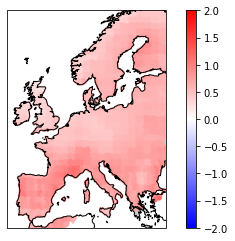

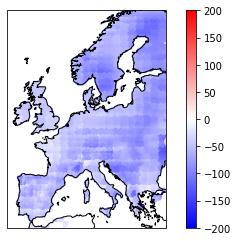

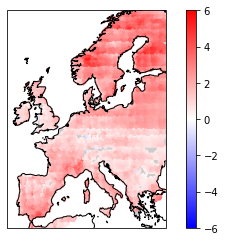

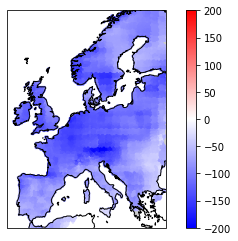

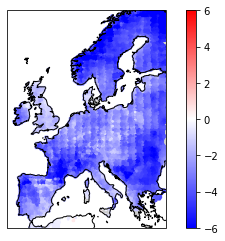

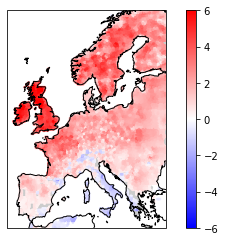

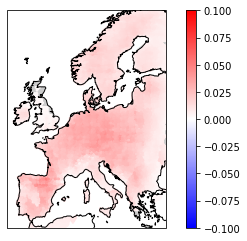

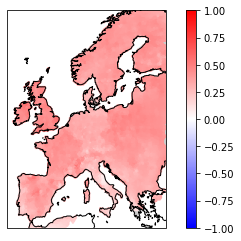

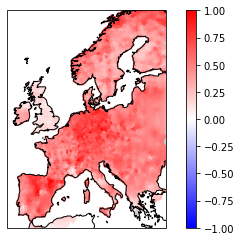

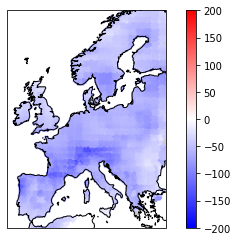

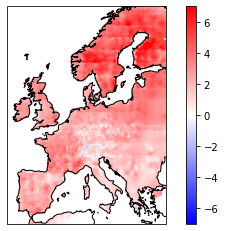

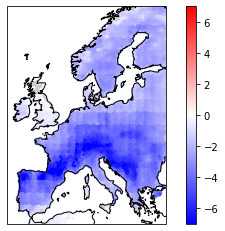

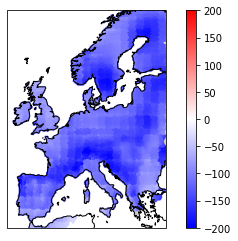

In [71]:
crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon'], station_locDF['lat']))

# cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin']

vmax = [2,200,6,200,6,6,0.1,1,1,200,7,7,200]
vmin = [-2,-200,-6,-200,-6,-6,-0.1,-1,-1,-200,-7,-7,-200]
cmap = ['bone','Wistia','RdBu']

for i in range(13):
    
    fig = plt.figure(figsize=(7, 4), facecolor = 'white')
    spec = gridspec.GridSpec(ncols=1, nrows=1,
                                 width_ratios=[1 for i in range(1)], wspace=0.1,
                                 hspace=0.3, height_ratios=[1 for i in range(1)])
    ax = fig.add_subplot(spec[0],projection=ccrs.PlateCarree())
    eu.plot(ax=ax,alpha=0.4,color="grey")
    geo_df.plot(column = cols[i],ax=ax,markersize=3, cmap = 'bwr', vmin = vmin[i], vmax = vmax[i], legend = True)
    ax.set_xlim(-12,30)
    ax.set_ylim(35,70)
    ax.coastlines()